# Fractals

## Complex Newton's Method

In [1]:
def newton(f, f_prime, x0, eps=1e-8, max_iter=1e5):
    x = x0
    for _ in range(int(max_iter)):
        y = f(x)
        z = f_prime(x)
        if z == 0 or abs(y) < eps:
            break
        x -= y/f_prime(x)
    return x, abs(y)

# our first function
def f(x):
    return x**2 + 1

def f_prime(x):
    return 2*x

newton(f, f_prime, 0.1 + 1j)


((-3.0097253200397857e-11+1.0000000000712528j), 1.5469716888295374e-10)

So, ignoring the really small terms, this is saying that we achieve a root of the function at $i$.

## Roots of $x^2 - 1$

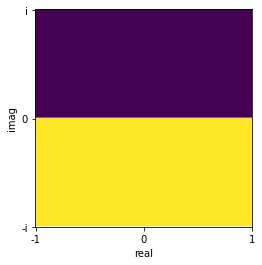

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# how many points to sample along each axis
l = 100

def make_plot(f, f_prime):
    vals = []
    nums = np.linspace(-1, 1, l)

    # evaluate newton on grid
    for a in nums:
        row = []
        for b in nums:
            x0 = a + 1j*b
            row.append([newton(f, f_prime, x0)[0]])
        vals.append(row)

    # so the axes are pointing the right directions
    vals = np.transpose(np.array(vals).reshape(l, l))

    # plotting
    plt.imshow(vals.imag)
    plt.xlabel("real")
    plt.ylabel("imag")

    plt.xticks([0, l//2, l], [-1, 0, 1])
    plt.yticks([0, l//2, l], ["i", 0, "-i"])

make_plot(f, f_prime)

This plot shows which root Newton's method converges to for different seed values on the polynomial expression $x^2 + 1$. This expression has two roots, $i$ (purple) and $-i$ (yellow). We can see that the method converges to whichever is closer. When the imaginary component is negative, the derivative in the imaginary direction is negative, and the value is pushed to $-i$. Similarily, positive seeds are pushed to positive $i$.

When the imaginary part of the seed is zero (at the boundary of the two colors), the imaginary component of the derivative is also zero. So, the method will not converge to either root.

## Roots of $x^3 - 1$

The polynomial expression $x^3 - 1$ has three roots: $1$, $-i^{2/3}$, and $i^{4/3}$.

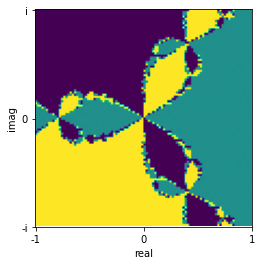

In [3]:
make_plot(lambda x:x**3 - 1, lambda x:3*x**2)

This plot shows the root that Newton's method converges to for different seed values. Rather than using an RGB code, I opted to just plot the magnitude of the imaginary part of the root that is found. For these polynomials, this is enough to distinguish the roots with different colors. In this plot, purple represents the $-i^{2/3}$. Blue represents $1$. Yellow represents $i^{4/3}$. We can see that, in a majority of cases, the seed will converge to the closest route. However, that is not always the case, and there are complicated patterns towards the center.

The function is cubic, so the only way for Newton's method to fail to converge is for it to get stuck at one of the nonzero optima of the function. Everywhere else, the derivative will be nonzero and pointed in the correct direction. So, the method will converge.

## Roots of $x^5 - 1$

In [4]:
import sympy as sp
x = sp.Symbol("x", complex=True)

[sp.N(i) for i in sp.solve(x**5 - 1)]

[1.00000000000000,
 0.309016994374947 - 0.951056516295154*I,
 0.309016994374947 + 0.951056516295154*I,
 -0.809016994374947 - 0.587785252292473*I,
 -0.809016994374947 + 0.587785252292473*I]

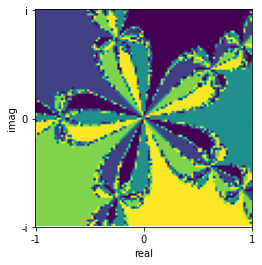

In [5]:
make_plot(lambda x:x**5 - 1, lambda x:5*x**4)

# Strange Attractors

## RK4 Implementation

In [6]:
class Lorenz:
    """RK4 approximation to the Lorenz system"""
    def __init__(self, x0, y0, z0, sig, b, r, k=0.01):
        self.sig = sig
        self.b = b
        self.r = r
        self.k = k

        self.x = [x0]
        self.y = [y0]
        self.z = [z0]
    
    def plot_title(self):
        return f"Lorenz System ($\sigma$ = {round(self.sig, 2)}, b = {round(self.b, 2)}, r = {round(self.r, 2)})"
    
    def dxdt(self, x, y, z):
        return self.sig*(y-x)

    def dydt(self, x, y, z):
        return self.r*x - y - x*z

    def dzdt(self, x, y, z):
        return x*y - self.b*z
    
    def rk4(self, x, y, z):
        k1x = self.k*self.dxdt(x, y, z)
        k1y = self.k*self.dydt(x, y, z)
        k1z = self.k*self.dzdt(x, y, z)
        
        k2x = self.k*self.dxdt(x+k1x/2, y+k1y/2, z+k1z/2)
        k2y = self.k*self.dydt(x+k1x/2, y+k1y/2, z+k1z/2) 
        k2z = self.k*self.dzdt(x+k1x/2, y+k1y/2, z+k1z/2)
        
        k3x = self.k*self.dxdt(x+k2x/2, y+k2y/2, z+k2z/2) 
        k3y = self.k*self.dydt(x+k2x/2, y+k2y/2, z+k2z/2) 
        k3z = self.k*self.dzdt(x+k2x/2, y+k2y/2, z+k2z/2)

        k4x = self.k*self.dxdt(x+k3x, y+k3y, z+k3z)
        k4y = self.k*self.dydt(x+k3x, y+k3y, z+k3z)
        k4z = self.k*self.dzdt(x+k3x, y+k3y, z+k3z)

        x_new = x + 1/6 * (k1x + 2*k2x + 2*k3x + k4x)
        y_new = y + 1/6 * (k1y + 2*k2y + 2*k3y + k4y)
        z_new = z + 1/6 * (k1z + 2*k2z + 2*k3z + k4z)

        return x_new, y_new, z_new
    
    def run(self, t_max):
        steps = int(t_max/self.k)
        for _ in range(steps):
            x_new, y_new, z_new = self.rk4(self.x[-1], self.y[-1], self.z[-1])
            self.x.append(x_new)
            self.y.append(y_new)
            self.z.append(z_new)
        
        self.x = np.array(self.x)
        self.y = np.array(self.y)
        self.z = np.array(self.z)

In [7]:
def plot_2d(lorenz):
    """Plots each component of the Lorenz system as a function of time"""
    plt.figure(figsize=(7, 4))
    t = np.arange(0, lorenz.k*len(lorenz.x), lorenz.k)
    plt.plot(t, lorenz.x, label="x", alpha=0.5)
    plt.plot(t, lorenz.y, label="y", alpha=0.5)
    plt.plot(t, lorenz.z, label="z", alpha=0.5)
    plt.legend()
    plt.title(lorenz.plot_title())
    plt.show()

In [8]:
def plot_3d(lorenz):
    """3d parametric plot of the Lorenz system"""
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(lorenz.x, lorenz.y, lorenz.z)

    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_title(lorenz.plot_title())

    plt.show()

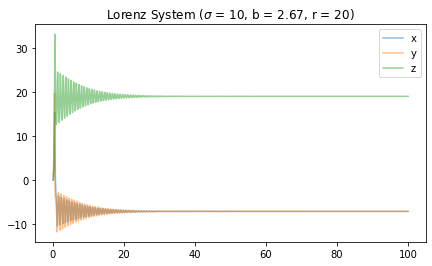

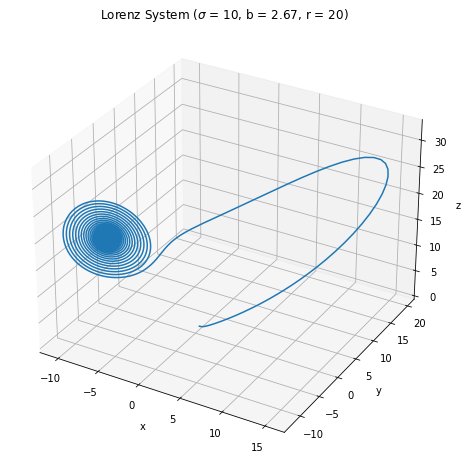

In [9]:
sim20 = Lorenz(x0=0, y0=1, z0=0, sig=10, b=8/3, r=20)
sim20.run(100)
plot_2d(sim20)
plot_3d(sim20)

We can see that when $r = 20$, the system approaches a point attractor relatively quickly. Then it never leaves this attractor.

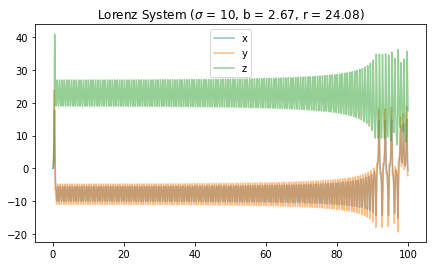

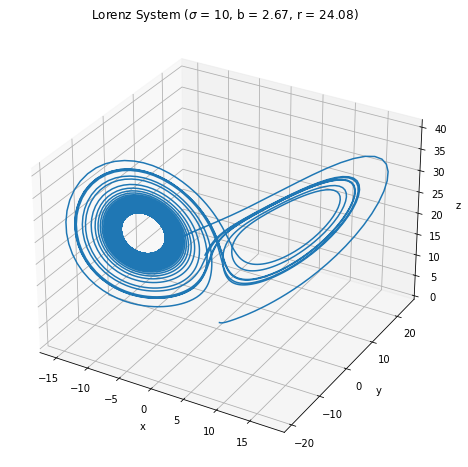

In [10]:
sim22 = Lorenz(x0=0, y0=1, z0=0, sig=10, b=8/3, r=24.08)
sim22.run(100)
plot_2d(sim22)
plot_3d(sim22)

The system reaches a critical point near $r = 24.08$. We get the first look at a more complicated attractor. Note the first plot. Although the system looks like it might be approaching a point attractor for the first 50 timesteps or so, it is actually getting less and less stable. Around timestep 80, variation in all three variables explodes and we reach the more complicated Lorenz attractor.

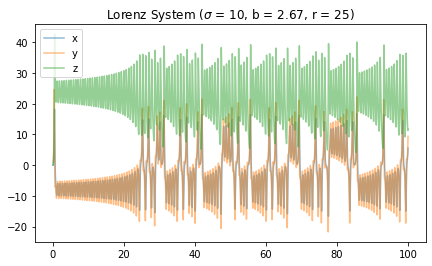

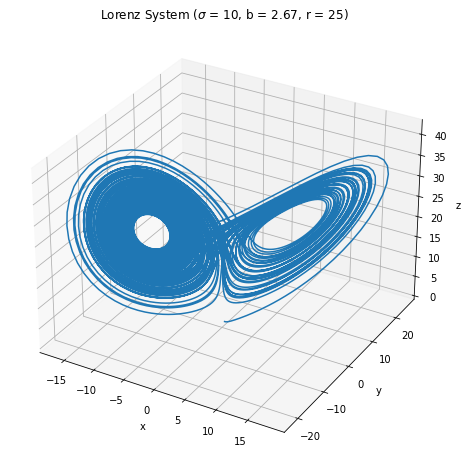

In [11]:
sim25 = Lorenz(x0=0, y0=1, z0=0, sig=10, b=8/3, r=25)
sim25.run(100)
plot_2d(sim25)
plot_3d(sim25)

At $r = 25$, the circular path the system seems to follow starts out with a tiny circle which spirals outwards and gets larger, until it reaches a certain point at which it leaves its current path and follows a totally new circle, creating seemingly concentrix/spiralling figure-8s. Most of the time is spent in the first circle with only occasional loops in the new circle.

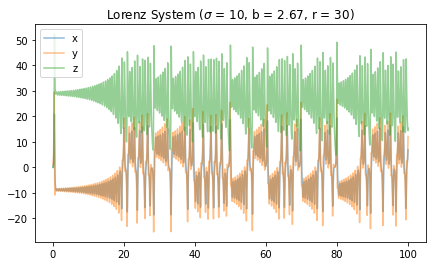

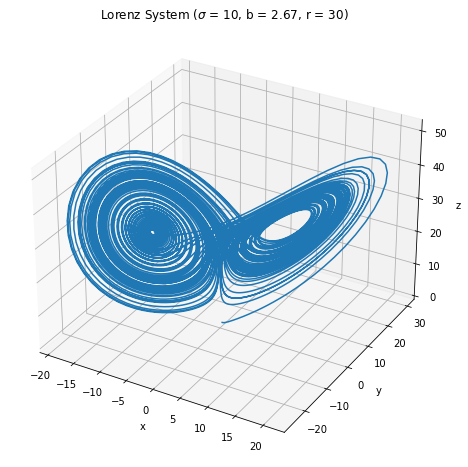

In [12]:
sim30 = Lorenz(x0=0, y0=1, z0=0, sig=10, b=8/3, r=30)
sim30.run(100)
plot_2d(sim30)
plot_3d(sim30)

 At $r = 30$, the system is comfortable settled into the Lorenz attractor. It reaches it quickly, around timestep 20, and it remains there. It distributes its time much more evenly between the two loops.

## Chaos

In [13]:
sim28 = Lorenz(x0=0, y0=1, z0=0, sig=10, b=8/3, r=28)
sim28.run(100)
sim28_nudged = Lorenz(x0=0, y0=1.0000001, z0=0, sig=10, b=8/3, r=28)
sim28_nudged.run(100)

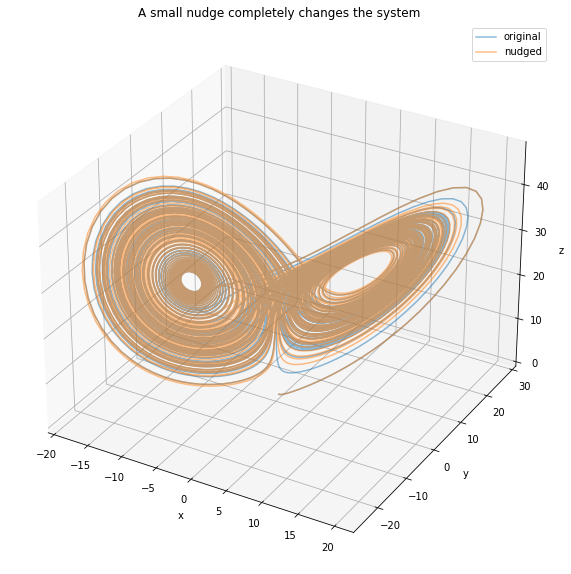

In [14]:
alpha = 0.5
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot(sim28.x, sim28.y, sim28.z, label="original", alpha=alpha)
ax.plot(sim28_nudged.x, sim28_nudged.y, sim28_nudged.z, label="nudged", alpha=alpha)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_title("A small nudge completely changes the system")
ax.legend()
plt.show()

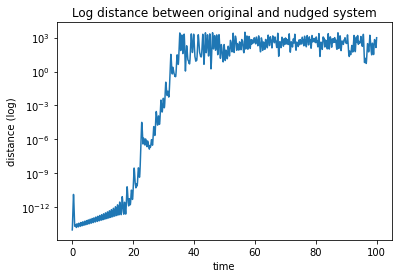

In [15]:
time = np.arange(0, sim28.k*len(sim28.x), sim28.k)
distance = (sim28.x - sim28_nudged.x)**2 + (sim28.y - sim28_nudged.y)**2 + (sim28.z - sim28_nudged.z)**2
plt.plot(time, distance)

plt.title("Log distance between original and nudged system")
plt.yscale("log")
plt.ylabel("distance (log)")
plt.xlabel("time")
plt.show()

A *tiny* nudge to $y$ results in significant divergence between the two systems fairly quickly. Both systems remain in the Lorenz attractor, so they are qualitatively pretty similar. It would be hard to tell which one is which just based on the graph. However, the actual positions are wildly different.

This is really interesting. It suggests that the way this differential equation is set up, it tends to separate (over time) systems which begin close together. And, this occurs even though both systems remain in the same attractor.

# PDE Solver

## Boundary Values
$$u_{1, j} = 0$$
$$u_{N, j} = 0$$
$$u_{i, 1} = 0$$
$$u_{i, N} = sin(2\pi x)$$

## Stencil

![](2021-12-15-18-27-55.png)

From the stencil, we see that we need to use the subsequent and previous points, i+1 & i-1 and j+1 & j-1 respectively, to calculate the 2nd derivative with respect to x and y at the point $u_{i,j}$. For this, we need two 2nd order central difference approximations, one for x and one for y.

$$
u_{xx(i, j)} = {u_{i + 1, j} - 2u_{i, j} + u_{i - 1, j} \over \Delta x^2} O(\Delta x^2)
$$

$$
u_{yy(i, j)} = {u_{i, j + 1}, - 2u_{i, j} + u_{i, j-1} \over \Delta y^2} + O(\Delta y^2)
$$

Because we are taking the second difference of both the x and y values at the point $u_{i, j}$, i.e. we are finding the slope on both sides of the point (in both directions) and finding the change in the slope per change in distance, the Taylor series approximation truncates the terms after the $x^2$ term. Since the manipulation of the Taylor series was done by adding the two series for $u_{i-1, j}$ and $u_{i+1, j}$ for $u_{xx}$, and $u_{i, j-1}$ and $u_{i, j+1}$ for $u_{yy}$, in both cases, the odd powers of x and y cancelled each other out meaning only the even powers, i.e. $\delta{x}^2$ and $\delta{x}^4$, etc. remained. Since we are trying to solve for the 2nd derivative, divide both sides by $\delta{x}^2$ which leaves a $\delta{x}^2$ in the numerator which gets truncated, meaning our errors for x and y are $O(\Delta{x}^2)$ and $O(\Delta{y}^2)$, respectively.

## Substitution

Let $\Delta x = \Delta y = d$. Then we can substitute into Laplace's equation, yielding,

$$
{u_{i + 1, j} - 2u_{i, j} + u_{i-1, j} \over d^2} + {u_{i, j+1} - 2u_{i, j} + u_{i, j-1} \over d^2} = 0
$$

Multiply both sides by $d^2$.

$$
4u_{i, j} - u_{i-1, j} - u_{i + 1, j} - u_{i, j - 1} - u_{i, j + 1} = 0
$$

## Matrix Equation of the Discretized System

When we substitute directly, we get:

$$
4u_{2,2} - u_{1, 2} - u_{3, 2} - u_{2, 1} - u_{2, 3} = 0
$$

$$
4u_{2, 3} - u_{1, 3} - u_{3, 3} - u_{2, 2} - u_{2, 1} = 0
$$

$$
4u_{3, 2} - u_{2, 2} - u_{4, 2} - u_{3, 1} - u_{3, 3} = 0
$$

$$
4u_{3,3} - u_{2, 3} - u_{4, 3} - u_{3, 2} - u_{3, 4} = 0
$$

We can use the boundary conditions to cancel a number of these terms, yielding,

$$
4u_{2, 2} - u_{3, 2} - u_{2, 3} = 0
$$

$$
4u_{2, 3} - u_{3, 3} - u_{2, 2} = 0
$$

$$
4u_{3, 2} - u_{2, 2} - u_{3, 3} = {\sqrt{3} \over 2}
$$

$$
4u_{3,3} - u_{2, 3} - u_{3, 2} = -{\sqrt{3} \over 2}
$$

We put the u's into the matrix in this order: $<u_{2,2}, u_{2,3}, u_{3,2}, u_{3,3}>$. Then, we can solve the systems equations using numpy as follows.

In [16]:
A = np.array([
    [4, -1, -1, 0],
    [-1, 4, 0, -1],
    [-1, 0, 4, -1],
    [0, -1, -1, 4]
])

b = np.array([0, 0, 3**0.5/2, -3**0.5/2])

np.linalg.solve(A, b)

array([ 0.03608439, -0.03608439,  0.18042196, -0.18042196])

So, 

$$
<u_{2,2}, u_{2,3}, u_{3,2}, u_{3,3}> =
<0.03608439, -0.03608439,  0.18042196, -0.18042196>
$$

# Another Transform

$$
\mathcal{L}\{f\}(s) = \int_0^\infty {f(t) \over e^{st}} dt
$$

## Linearity

$$
\mathcal{L}\{f + g\}(s) = \int_0^\infty {f(t) + g(t) \over e^{st}} dt
$$

Distribute the integral,

$$
\int_0^\infty {f(t) \over e^{st}} dt + \int_0^\infty {g(t) \over e^{st}} dt
$$

Which we recognize,

$$
\mathcal{L}\{f\}(s) + \mathcal{L}\{g\}(s)
$$

## Existence

The transform will only exist if that infinite integral exists. Sometimes, it doesn't. For example, let $f(x) = e^x$.

$$
\mathcal{L}\{f\}(s) = \int_0^\infty {f(t) \over e^{st}} dt
$$

$$
\mathcal{L}\{f\}(s) = \int_0^\infty {e^t \over e^{st}} dt
$$

$$
\mathcal{L}\{f\}(s) = \int_0^\infty e^{s} dt
$$

The $e^s$ is always positive. So, the integral diverges.

## Step Function

Let $u(x)$ represent the step function, such that,

$$
u(x) =
\left\{
\begin{array}{ll}
      0 & x \lt 0 \\
      1 & x \ge 0
\end{array} 
\right.
$$

We can get an expression for the Laplace transform.

$$
\mathcal{L}\{u\}(s) = \int_0^\infty {u(t) \over e^{st}} dt
$$

Since $u(t)$ is always 1 on the domain of the integral, we can replace it with a one.

$$
\mathcal{L}\{u\}(s) = \int_0^\infty e^{-st} dt
$$

$$
= {1 \over -s} \int_0^\infty -s e^{-st} dt
$$

$$
= {1 \over -s} \Big[ e^{-st} \Big]_0^\infty + C
$$

$$
= {1 \over -s} \lim_{t \to \infty} (e^{-st} - 1) + C
$$

When $s$ is negative, the sign of the exponent will be positive, and the whole thing will go to infinity. When $s$ is zero, the exponent will be zero and so the $\exp$ expression will be 1. So, the whole expression will be $0$. When $s$ is positive, the sign if the exponent will be negative and the $\exp$ goes away. We just end up with a $-1$ from the limit and a $1/s$ from the entire expression.

$$
\mathcal{L}\{u\}(s) = 
\left\{
\begin{array}{ll}
      \infty & x \lt 0 \\
      C & s = 0\\
      C/s & s \gt 0
\end{array} 
\right.
$$

## Laplace of Derivative

Let, $$\mathcal{L}\{y\}(s) = Y$$

Now, we compute the Laplace transform of $y'$.

$$
\mathcal{L}\{y'\}(s) = \int_0^\infty {y'(t) \over e^{st}} dt
$$

Integrate by parts

$$
\begin{array}{ll}
    v = y & dv = y'\\
    u = e^{-st} & du = -se^{-st}
\end{array}
$$

$$
\mathcal{L}\{y'\}(s) = \big[y e^{-st} \big]_0^\infty - \int_0^\infty -se^{-st}y dt
$$

$$
\mathcal{L}\{y'\}(s) = \big[y e^{-st} \big]_0^\infty + s \int_0^\infty e^{-st}y dt
$$

$$
\mathcal{L}\{y'\}(s) = \big[y e^{-st} \big]_0^\infty + s Y
$$

At $s = \infty$, the left term will just be zero, because there is a negative $s$ in the exponent. At $s=0$, the exponential term will be one. So, the whole left hand term just evaluates to $-y(0)$.

$$
\mathcal{L}\{y'\}(s) = s Y - y(0)
$$

So, when we differentiate the function, we multiply the Laplace transform by $s$ and subtract the initial condition.

## Solving the IVP

Let $u(t)$ represent the step function. Assume $y$ is a function of $t$. We want to solve the IVP,

$$
y' + y = u
$$

With initial condition $y(0) = 1$

Laplace both sides:

$$
\mathcal{L}(y' + y) = \mathcal{L}u
$$

By linearity,

$$
\mathcal{L}y' + \mathcal{L}y = \mathcal{L}u
$$

Use our formula for Laplace of derivative, continuing to use $Y$ to represent the Laplace transform of $y$.

$$
(sY - y(0)) + Y = \mathcal{L}u
$$

From the initial condition, we know that $y(0) = 1$.

$$
(s + 1)Y - 1 = \mathcal{L}u
$$

$$
Y = {\mathcal{L}u + 1 \over s + 1}
$$

At every time greater than zero, we can substitute $C/s$ in for $\mathcal{L}u$, yielding,

$$
Y(s) = {C/s + 1 \over s + 1}
$$

I'm not sure how to get $C$.

## Using the Laplace Tranform

The Laplace transform is nice because it gives us a way to replace differentiation with multiplication. Derivatives on $y$ become multiplication on $Y$. In addition, it's linear. So, a linear combination of derivatives on $y$ is equivalent to a polynomial of $Y$. Laplace takes in calculus and gives us algebra.

# Reflection

**Leo**

I got better at coding this semester, especially at using numpy and scipy. I also feel like I know a lot more about the theory around scientific computing. I have a better understanding of how these work under the hood (from CS154), and I'm a lot more familiar with the documentation. I think this was probably the biggest gain in terms of things I will use in the future.

I still feel pretty shaky on many of the mathier parts, especially around differential equations. I never really understood integrating factors, and I think I would need help to push through any of the harder analytical problems. I do feel equipped to use numerical solvers though, and I think I know enough of the theory to be useful. The ideas around bifurcations, steady states, and systems of linear equations are all fairly simple conceptually once you understand them, and I think I will remember them. For example, in CS166, I had to do a theoretical approximation to a simulation we were writing, so I used a linear system of differential equations like we learned about in CS154.

**Sean**

I have grown as a computational scientist this semester in that I have learnt to try thinking about the world in terms of systems that change over time which can potentially be modelled with a set of differential equations. I have gone from struggling to get code to work for some assignments to figuring out the entirety of the code for my half of this assignment. I have learnt how to think about defining a function both from the “top-down” (explicitly defining it for all values in the domain) and from the “bottom-up” (defining how the slope changes at each time step, and using those slopes to approximate the subsequent values).

The most interesting discussions were applying some of the linear algebra concepts to solving differential equations. I really enjoyed the course last semester and it was fun seeing it used again. I thoroughly enjoyed the Fourier Series and Fourier Transform sections and I will now always think about functions in terms of their decomposition into sinusoids. 

Most of the maths went over my head when trying to do the readings, and even for the majority of the class, but sometimes there were moments that cleared up previous and current confusions. Getting the code to work was always the most difficult part for me for nearly every topic.